In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import time
from scipy import stats
from scipy.optimize import curve_fit
import pandas as pd

### Natural images

In [5]:
def convert_cd_to_photons(cdVal,wavelength=475):
    # From Madhura's matlab script
    cdSrPerWatt=683       # Wikipedia for Candela
    h=6.62607 * 10**(-34) # Planck's constant, J.s
    c=299792458           # speed of light, m/s
    acceptanceAngle=8.23  # degrees, from Gonzalez-Bellido et al
    ommatidiumDia=16.85*10**(-6) # m, Gonzalez-Bellido et al, 2011 Supp

    #converts cd/sq m values to photons per s per receptor
    #wavelength has to be in nm
    ## import photopic luminosity function (LS-100 uses it) and convert cd to watt
    #luminosity = pd.read_fwf('photopic luminosity function.txt')
    #read_in_table = pd.read_fwf('photopic luminosity function.txt')
    ##spectrum = csvread('relative spectral distribution_LED panels.csv')
    ##spectrum=spectrum(1:2:end,:); # downsampling to match luminosity function data
    luminosity_df = pd.read_csv('photopic_luminosity_function.txt', sep="\t",
                                header=None)
    luminosity = luminosity_df[luminosity_df[0]==wavelength][1]
    luminosity = float(luminosity)
    wattVal = cdVal/(cdSrPerWatt*luminosity)   # in the row of wavelength (multiples of 5)
    ## convert cd to photons per s per sr per sq m
    energyPerPhoton=h*c/(wavelength*10**-9)     # J
    photonsPerSSrSqM=wattVal/energyPerPhoton   # from here, we work on replacing per sr per sq m by per receptor
    ## convert acceptance angle to steradians (Integration over Gaussian angular sensitivity function, Dubs et al 1981)
    acceptanceAngleRad=acceptanceAngle*np.pi/180  # conversion to Rad
    acceptanceSteradians=acceptanceAngleRad**2*np.pi/(4*np.log(2))
    ## flux to one ommatidium/receptor
    ommatidiumArea=np.pi*(ommatidiumDia/2)**2      # sq m
    photonVal=photonsPerSSrSqM*ommatidiumArea*acceptanceSteradians # as required

    return photonVal

def load_Data_wide_field():
    # natural scenes from the original data set have been previously saved in a unique matrix file. 
    if par_dset_wide == 0:
        Data_array = np.loadtxt("Data/Data_array_WideField_sunset_woods"+str(res_array[par_res])+".txt")
        size, Nmin = np.array(np.loadtxt("Data/SizeAndNmin_WideField_sunset_woods"+str(res_array[par_res])+".txt"), dtype = int)
        N_images_array = np.array([10, 11, 12, 13, 14, 15])
        N_images_size = N_images_array.size
        
        Data = np.zeros((N_images_size, size, size))
        counter_i = -1
        for i in N_images_array:
            counter_i += 1 
            Data[counter_i,:,:] = np.reshape(Data_array[i,:], (size, size)) 
        return convert_cd_to_photons(Data,wavelength=475), convert_cd_to_photons(Data_array,wavelength=475), size, Nmin
    else: 
        Data_array = np.loadtxt("Data/Data_array_WideField_sky_horizon_allday"+str(res_array[par_res])+".txt")
        size, Nmin = np.array(np.loadtxt("Data/SizeAndNmin_WideField_sky_horizon_allday"+str(res_array[par_res])+".txt"), dtype = int)
        
        N_images_array = np.array([7, 25, 22, 13, 15]) # Here I am just taking the images with the best luminance variations from the whole data set. Then, I make them overlap.
        N_images_size = N_images_array.size
        
        Data_ = np.zeros((N_images_size, size, size))
        counter_i = -1
        for i in N_images_array:
            counter_i += 1
            Data_[counter_i,:,:] = np.reshape(Data_array[i,:], (size, size))
            
        idx_y_ = 48
        idx_x_ = 400
        idx_y_max_ = 600 + 2*idx_y_
        size_new = idx_y_max_ - idx_y_

        size = size_new - idx_y_
        Data = np.zeros((N_images_size, size, size))
        
        counter_im = -1
        for i_im in N_images_array:
            counter_im += 1
            if i_im == 25:
                idx_y = 48
                idx_x = idx_x_
                idx_y_max = size_new + (idx_y - idx_y_)

            if i_im == 22:
                idx_y = 75
                idx_x = idx_x_
                idx_y_max = size_new + (idx_y - idx_y_)

            if i_im == 7:
                idx_y = 0
                idx_x = idx_x_
                idx_y_max = size_new + (idx_y - idx_y_)

            if i_im == 15:
                idx_y = 0
                idx_x = idx_x_
                idx_y_max = size_new + (idx_y - idx_y_)

            if i_im == 13:
                idx_y = 90
                idx_x = idx_x_
                idx_y_max = size_new + (idx_y - idx_y_)
        
            Data[counter_im, :, :] = Data_[counter_im, idx_x:,idx_y:idx_y_max]
            
    
        return convert_cd_to_photons(Data,wavelength=475), convert_cd_to_photons(Data_array,wavelength=475), size, Nmin

def Visualize_images(Data_O_):
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    Counter_i = -1
    for i in N_idist_plot:
        Counter_i += 1
        ax[Counter_i].imshow(Data_O_[i,:,:], cmap = 'Greys_r', aspect = 'auto')
    plt.show()

In [ ]:
#----- Set parameters to load original images ---------
Par_DataSet = 1 # 0 If closeup. 1 if wide field. For Fig. 3 choose 1. 
par_dset_wide = 1 # 0 if woods (Fig. 3A), 1 if horizon (Fig. 3G).
N_dset = 1 # Larger for CloseUp
string = ['woods', 'horizon']
res_array = ['Original', 'Filtered']
par_res = 0 # 0 if original. 1 if filtered. for Fig 3, choose 0.

#----- Load original images ---------
Data_O, Data_array_O, size, Nmin = load_Data_wide_field()

### L3 responses

In [57]:
def L3_neurons_LinearFit(): # We model L3 voltage responses in the code " ". The amplitude responses can be fitted by using the amplitude from experimental analysis matching the model. 
    L3_amp_exp = np.loadtxt("Data/L3_Amp_exp.txt") # Amplitude of L3 responses from experimnts. 
    Slope_L3, Cut_L3  = np.polyfit(np.log10(L0_array), np.mean(L3_amp_exp, axis = 1), 1) #Linear fit of L3 response.
    return Slope_L3, Cut_L3

def Normalization_L3():
    Respomse_Tm9_time = np.zeros((N_ite, Nl, Nstim, Nt_st))
    Amplitude = np.zeros((N_ite, Nl, Nstim))
    
    time_array_st = np.arange(T_min_st, T_max_st, dt_st)
    St_epoch = np.sin(Omega_st*2*np.pi*time_array_st)
    
    xx, yy = np.meshgrid(space_array_st, space_array_st)
    Dm_pooling = (yy - Nx_st_half)**2 + (xx - Nx_st_half)**2 < (Circular_pooling_size/2)**2 
    idx_pooling = np.where(np.reshape(Dm_pooling,  Nx_st*Nx_st))[0]
    Counter_l0 = -1
    for i_L0 in L0_array:
        Counter_l0 += 1
        counter_pooling = -1
        for Stim_circular_size in Stim_circular_array:
            counter_pooling += 1
            Mean = np.zeros(N_ite)
            for ite in range(N_ite):
                L3_pooled, Screen_L3 = Spatial_pooling_L3(np.random.uniform(), Stim_circular_size, i_L0)
                Mean[ite] = np.mean(np.reshape(L3_pooled, Nx_st*Nx_st)[idx_pooling])
                L3_ampl = np.log10((10**(Cut_L3))*((i_L0 - L3_num)**Slope_L3))
                Respomse_Tm9_time[ite, Counter_l0, counter_pooling,:] = (( ( ((L3_ampl)*(St_epoch)*0.5)) )**ExpNum/(g0 + alpha_norm*(Mean[ite])**ExpDen))
                Amplitude[ite, Counter_l0, counter_pooling] = (np.max(Respomse_Tm9_time[ite, Counter_l0, counter_pooling,:]) - np.min(Respomse_Tm9_time[ite, Counter_l0, counter_pooling,:]))/2
    return Respomse_Tm9_time, Amplitude

In [116]:
#--- Luminance parameters used in the expeirment ----
L0_exp_min = 1.2E4
L0_exp_max = 10.6E4
L0_array = np.array([L0_exp_min, 2.6E4, 5.3E4, 7.9E4, L0_exp_max])
Nl = L0_array.size

#---- Calculate L3 amplitude parameters -------
Slope_L3, Cut_L3 = L3_neurons_LinearFit()

#---- Calculate L3 responses to images -------
# L3_image = np.log10((10**(Cut_L3))*((Data_O_shifted)**Slope_L3) + np.spacing(1))
# for i_image in range(L3_image.shape[0]):
#     np.savetxt("Data/L3_responses/L3_image_responses_"+str(string[par_dset_wide])+"_"+str(i_image)+".txt", L3_image[i_image, :, :])

#--- Load data from Data/ ----
L3_image = np.zeros((Data_O.shape[0], size, size))
if par_dset_wide == 0:
    N_images_array = np.array([10, 11, 12, 13, 14, 15]) # Array of images used in the analysis for Set 1. 
    counter_im = -1
    for i_image in N_images_array:
        counter_im += 1
        L3_image[counter_im,:,:] = np.loadtxt("Data/L3_responses/L3_image_responses_"+str(string[par_dset_wide])+"_"+str(i_image)+".txt")
else:
    N_images_array = np.array([7, 25, 22, 13, 15]) # Array of images used in the analysis for Set 1.
    counter_im = -1
    for i_im in N_images_array:
        counter_im += 1
        
        idx_y_ = 48
        idx_x_ = 400
        idx_y_max_ = 600 + 2*idx_y_
        size_new = idx_y_max_ - idx_y_
        
        if i_im == 25:
            idx_y = 48
            idx_x = idx_x_
            idx_y_max = size_new + (idx_y - idx_y_)

        if i_im == 22:
            idx_y = 75
            idx_x = idx_x_
            idx_y_max = size_new + (idx_y - idx_y_)

        if i_im == 7:
            idx_y = 0
            idx_x = idx_x_
            idx_y_max = size_new + (idx_y - idx_y_)

        if i_im == 15:
            idx_y = 0
            idx_x = idx_x_
            idx_y_max = size_new + (idx_y - idx_y_)

        if i_im == 13:
            idx_y = 90
            idx_x = idx_x_
            idx_y_max = size_new + (idx_y - idx_y_)

        L3_image[counter_im,:,:] = np.loadtxt("Data/L3_responses/L3_image_responses_"+str(string[par_dset_wide])+"_"+str(i_im)+".txt")[idx_x:,idx_y:idx_y_max]

In [ ]:
# ------- Visualize Raw images and L3 outputs -------- 

if par_dset_wide == 0:
    N_idist_plot = np.array([0, 5]) # 0-5 From sunny to shade conditions.
else:
    N_idist_plot = np.array([0, 4]) # 0-5 From shade to sunny conditions
    
print("----- Raw image -----")
Visualize_images(Data_O)
print("----- L3 responses -----")
Visualize_images(L3_image)

### Normalized L3 responses

In [12]:
def Neighbours_circle(Nneigh, px_x, px_y):
    size_half = int(size/2)
    x_array = np.linspace(-size_half, size_half, size)
    y_array = np.linspace(-size_half, size_half, size)
    
    xx, yy = np.meshgrid(x_array, y_array)
    zz = np.sqrt((xx - px_x)**2 + (yy-px_y)**2) < Nneigh
    zz = np.reshape(zz, size*size)
    idx_zz = np.where(zz)[0]
    
    return np.array(idx_zz/size, dtype = int), idx_zz%size

def L3_normalization(): 
    print("------------------")
    print("See Cluster codes")
    print("------------------")

def Visualize_PoolingSizes():
    px_array = np.array([ 1, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80],dtype=int)
    px_array = np.array(46*0.1*px_array, dtype = int)

    for i_pooling in px_array:
        print("Pooling size (px) = ", i_pooling)
        print("Degrees = ", 2*int(i_pooling/46))
        zz = np.zeros((size, size))
        px_x_array, px_y_array = Neighbours_circle(i_pooling, 0, 0)
        zz[px_x_array, px_y_array] = 1
        plt.figure(figsize = (2, 2))
        plt.imshow(zz, cmap = 'Greys')
        plt.show()

In [ ]:
#L3_normalization() # Normalization of L3 responses to Natural scenes is done in the codes "Normalizing_images.py" and "Normalizing_images_TrayectorySamples.py"

#----- Calculations done in the cluster ----- #

if par_dset_wide == 0:
    Tr_type = 1  # Which trajectory
    N_images_array_2 = np.arange(10, 16) # The images from the dataset
    N_images = N_images_array_2.size
    N_idist_plot = np.array([15, 10]) # From 10 to 15. 
    N_pooling_array = np.array(46*0.1*np.array([ 1, 3, 4, 5, 6, 8, 10, 13, 15, 18, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165]), dtype = int)
else:
    Tr_type = 1 # Which trajectory
    N_images_array_2 = np.array([7, 25, 22, 13, 15]) # The images from the dataset
    N_images = N_images_array_2.size 
    N_pooling_array = np.array(46*0.1*np.array([ 1, 3, 4, 5, 6, 8, 10, 13, 15, 18, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 250, 300, 400]), dtype = int)        
N_pooling = N_pooling_array.size

N_T_samples_ = 30
N_tr_ = 20
if par_dset_wide == 0:
    T_x_reshaped_ = np.array(np.loadtxt("Cluster_codes/Data_trajectories/T_X.txt"), dtype = int)
    if Tr_type == 1:
        T_y_reshaped_ = -np.array(np.loadtxt("Cluster_codes/Data_trajectories/T_Y.txt"), dtype = int)
    else:
        T_y_reshaped_ = np.array(np.loadtxt("Cluster_codes/Data_trajectories/T_Y.txt"), dtype = int)
    T_y_reshaped = T_x_reshaped_ + int(size/2)
    T_x_reshaped = T_y_reshaped_ + int(size/2)
else:
    T_x_reshaped_ = np.array(np.loadtxt("Cluster_codes/Data_trajectories/T_X_horizon.txt"), dtype = int)
    T_y_reshaped_ = np.array(np.loadtxt("Cluster_codes/Data_trajectories/T_Y_horizon.txt"), dtype = int)
    if Tr_type == 1:
        T_y_reshaped = T_x_reshaped_ + int(size/2)
        T_x_reshaped = -T_y_reshaped_ + int(size/2) + 200
    else:
        T_y_reshaped = T_y_reshaped_ + int(size/2) - 220
        T_x_reshaped = T_x_reshaped_ + int(size/2)
    

L3_norm = -10*np.ones((N_images, N_pooling, size, size))
counter_image = -1
for i_image in N_images_array_2:
    counter_image += 1
    print(i_image)
    counter_pooling = -1
    for i_pooling in N_pooling_array:
        counter_pooling += 1 
#         if i_pooling<206:
        if i_pooling<0:
            if np.logical_and(i_image <= N_idist_plot[0], i_image >= N_idist_plot[1]):
                L3_norm[counter_image,counter_pooling,:,:] = np.loadtxt("Data/L3_responses/L3_image_normalized_responses_"+str(string[par_dset_wide])+"_"+str(i_image)+"_pooling_"+str(i_pooling)+".txt")
        else:
            if par_dset_wide == 0:
                L3_norm_traject_points = np.loadtxt("Data/L3_responses/L3_image_normalized_responses_"+str(string[par_dset_wide])+"_"+str(i_image)+"_pooling_"+str(i_pooling)+"_trajectories_"+str(Tr_type)+".txt") 
            else:
                L3_norm_traject_points = np.loadtxt("Data/L3_responses/L3_image_normalized_responses_"+str(string[par_dset_wide])+"_"+str(i_image)+"_pooling_"+str(i_pooling)+"_trajectories_"+str(Tr_type)+".txt") 

            for i_tr_1 in range(N_tr_):
                for i_tr_2 in range(N_T_samples_):
                    L3_norm[counter_image,counter_pooling,T_x_reshaped[i_tr_1, i_tr_2],T_y_reshaped[i_tr_1, i_tr_2]] = L3_norm_traject_points[i_tr_1, i_tr_2]
                

In [ ]:
# Visualize normalized responses to nat. scenes.

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].imshow(L3_image[0,:,:], cmap = 'Greys_r', aspect = 'auto')
ax[1].imshow(L3_image[4,:,:], cmap = 'Greys_r', aspect = 'auto')
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
#plt.savefig("Plots/L3_responses_plot.pdf", bbox_inches = 'tight', dpi = 300)
plt.show()

for i_pooling in range(5, N_pooling_array.size-34):
    Counter_i = -1
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    for i in np.array([0, 5]):
        Counter_i += 1
        ax[Counter_i].imshow(L3_norm[i,i_pooling,:,:], cmap = 'Greys_r', aspect = 'auto')
        ax[Counter_i].set_yticklabels([])
        ax[Counter_i].set_xticklabels([])
    #plt.savefig("Plots/L3_responses_normalized_pooling_"+str(N_pooling_array[i_pooling])+".pdf", bbox_inches = 'tight', dpi = 300)
    plt.show()

### Sampling contrast with a simulated trajectory

In [99]:
def Trajectory(N_T_samples):
    
    size_half = int(size/2)
    x_array = np.linspace(-size_half, size_half, size)
    y_array = np.linspace(-size_half, size_half, size)
    zz = np.zeros((size, size))

    omega_x = 3/size
    z =  30*np.sin(2*np.pi*omega_x*x_array) + 0.3*x_array + 60*np.random.random(size)
    idx_rand = np.sort(np.random.choice(np.arange(size), N_T_samples, replace = False))
    
    return np.array(x_array[idx_rand], dtype = int), np.array(z[idx_rand], dtype = int)

def Trajectory_horizon(N_T_samples):
    
    size_half = int(size/2)
    x_array = np.linspace(-size_half, size_half, size)
    y_array = np.linspace(-size_half, size_half, size)
    zz = np.zeros((size, size))

    omega_x = 3/size
    z =  10*np.sin(2*np.pi*omega_x*x_array) + 0.1*x_array + 60*np.random.random(size)
    idx_rand = np.sort(np.random.choice(np.arange(size), N_T_samples, replace = False))
    
    return np.array(x_array[idx_rand], dtype = int), np.array(z[idx_rand], dtype = int)

def Visualize_trajectory(Images, N_idist_plot_, T_x, T_y):
    size_half = int(size/2)
    fig, ax = plt.subplots(1, 2, figsize = (9, 4))
    ax[0].imshow(Images[N_idist_plot_[0],:,:], extent=[-size_half, size_half, -size_half, size_half], cmap = 'Greys_r')
    for i_T in range(N_tr):
        ax[0].plot(T_x[i_T, 5:-5], T_y[i_T, 5:-5], linewidth = 2, marker = '.', markersize = 7)
#     ax[1].imshow(Images[N_idist_plot_[1],:,:], extent=[-size_half, size_half, -size_half, size_half], cmap = 'Greys_r')
    for i_T in range(N_tr):
        ax[1].plot(T_x[i_T, 5:-5], T_y[i_T, 5:-5], linewidth = 2, marker = '.', markersize = 7)
#     ax[1].plot(T_x[5:-5], T_y[5:-5], linewidth = 1, marker = '.', color = 'orange')
    ax[1].imshow(Images[N_idist_plot_[1],:,:], extent=[-size_half, size_half, -size_half, size_half], cmap = 'Greys_r')
    plt.show()
    

In [120]:
#---- Load sample trajectories
N_T_samples = 30
N_tr = 10
if par_dset_wide == 0:
    T_x_ = np.array(np.loadtxt("Cluster_codes/Data_trajectories/T_X.txt"), dtype = int)
    T_y_ = np.array(np.loadtxt("Cluster_codes/Data_trajectories/T_Y.txt"), dtype = int)
    
    init_tr = 0
    T_x__ = T_x_[init_tr:N_tr+init_tr, :]
    if Tr_type == 1:
        T_y__ = -T_y_[init_tr:N_tr+init_tr, :]
    else: 
        T_y__ = T_y_[init_tr:N_tr+init_tr, :]
else:
    T_x_ = np.array(np.loadtxt("Cluster_codes/Data_trajectories/T_X_horizon.txt"), dtype = int)
    T_y_ = np.array(np.loadtxt("Cluster_codes/Data_trajectories/T_Y_horizon.txt"), dtype = int)
    init_tr = 0
    T_x__ = T_x_[init_tr:N_tr+init_tr, :]
    T_y__ = T_y_[init_tr:N_tr+init_tr, :]

#---- Save trajectories ----
# size = 1000
# N_T_samples = 30
# N_tr = 20
# T_x = np.zeros((N_tr, N_T_samples))
# T_y = np.zeros((N_tr, N_T_samples))
# for i_T in range(N_tr):
#     T_x[i_T, :], T_y[i_T, :] = Trajectory(N_T_samples)
#np.savetxt("Cluster_codes/Data_trajectories/T_X.txt", T_x)
#np.savetxt("Cluster_codes/Data_trajectories/T_Y.txt", T_y)

In [ ]:
#Visualize trajectory points on the scene

L3_image_copy = np.copy(L3_image)
Tr_idx_ = 5
if par_dset_wide == 0:
    T_y_c = T_x__ + int(size/2)
    T_x_c = T_y__ + int(size/2) 
    for i in range(5):

        L3_image_copy[0, T_x_c[Tr_idx_, :], T_y_c[Tr_idx_, :]] = 20
        L3_image_copy[0, T_x_c[Tr_idx_, :]+i, T_y_c[Tr_idx_, :]+i] = 20
        L3_image_copy[0, T_x_c[Tr_idx_, :]-i, T_y_c[Tr_idx_, :]-i] = 20
        L3_image_copy[0, T_x_c[Tr_idx_, :]+i, T_y_c[Tr_idx_, :]-i] = 20
        L3_image_copy[0, T_x_c[Tr_idx_, :]-i, T_y_c[Tr_idx_, :]+i] = 20

    #L3_image_copy_ = np.rot90(L3_image_copy[10,:,:])
    plt.imshow(L3_image_copy[0, :,:], cmap = 'Greys_r')

else:
    if Tr_type == 1:
        T_y_c = T_x__ + int(size/2)
        T_x_c = -T_y__ + int(size/2) + 220
    else:
        T_y_c = T_y__ + int(size/2) - 220
        T_x_c = T_x__ + int(size/2) 
    for i in range(5):

        L3_image_copy[0, T_x_c[Tr_idx_, :], T_y_c[Tr_idx_, :]] = 20
        L3_image_copy[0, T_x_c[Tr_idx_, :]+i, T_y_c[Tr_idx_, :]+i] = 20
        L3_image_copy[0, T_x_c[Tr_idx_, :]-i, T_y_c[Tr_idx_, :]-i] = 20
        L3_image_copy[0, T_x_c[Tr_idx_, :]+i, T_y_c[Tr_idx_, :]-i] = 20
        L3_image_copy[0, T_x_c[Tr_idx_, :]-i, T_y_c[Tr_idx_, :]+i] = 20

    #L3_image_copy_ = np.rot90(L3_image_copy[10,:,:])
    plt.imshow(L3_image_copy[0, :,:], cmap = 'Greys_r')

### Statistics of responses

In [112]:
def Gauss(x, A, B, x0):
    y = 1/np.sqrt(2*np.pi*(1/B))*np.exp(-B*(x-x0)**2)
    return y

def Responses_from_trajectory(Responses, N_idist_plot_):
    Contrast_1 = 0
    Contrast_2 = 0
    for i_T in range(N_tr):
        c_measure_1 = Responses[N_idist_plot_[0], T_x[i_T, :], T_y[i_T, :]]#L3_image[N_idist_plot[0], T_x, T_y]
        c_measure_2 = Responses[N_idist_plot_[1], T_x[i_T, :], T_y[i_T, :]]#L3_image[N_idist_plot[1], T_x, T_y]
        if np.any((c_measure_1<0, c_measure_2<0)):
            print("WARNING! Neg values", np.where(c_measure_1<0)[0].size + np.where(c_measure_2<0)[0].size)
        Contrast_1 = np.append(Contrast_1, c_measure_1) 
        Contrast_2 = np.append(Contrast_2, c_measure_2) 
    max_c = np.max(( np.abs(Contrast_1[1:]), np.abs(Contrast_2[1:]) ))
    
    return Contrast_1[1:]/max_c, Contrast_2[1:]/max_c 

def Dist_responses(min_hist, max_hist, contrast_1, contrast_2):
    
    x_array_ = np.arange(min_hist, max_hist, 0.01)
    kernel = stats.gaussian_kde(contrast_1)
    dist1 = kernel(x_array_)
    kernel = stats.gaussian_kde(contrast_2)
    dist2 = kernel(x_array_)
    
    return x_array_, dist1, dist2

def Gaussian_fit(x_array_, dist, bounds):
    parameters, covariance = curve_fit(Gauss, x_array_, dist, method = 'trf', bounds = bounds)
    return parameters

def Loss_function(dist, dist2):
    return np.sqrt((Weight1*dist)**2 + (Weight2*dist2)**2)

# def Loss_function(dist, sigma1, sigma2):
#     return np.sqrt((dist)**2 + (sigma1-sigma2)**2)

def Visualize_distributions(x_array_, dist1, dist2, parameters, par_string, i_pooling):
    if par_string == 1:
        plt.figure(figsize = (10, 3))
    else:
        plt.figure(figsize = (10, 3))
    plt.plot(x_array_, dist1, color = 'k')
    plt.fill_between(x_array_, dist1, alpha = 0.5, color = 'k', label = 'Shade')
    plt.plot(x_array_, dist2, color = 'k')
    plt.fill_between(x_array_, dist2, alpha = 0.5, color = 'orange', label = 'Sun')
    fit_A_l3 = parameters[0]
    fit_B_l3 = parameters[1]
    fit_C_l3 = parameters[2]
    fit_y_l3 = Gauss(x_array_, fit_A_l3, fit_B_l3, fit_C_l3)
#     plt.plot(x_array_, fit_y_l3, color = 'darkgreen', label = 'Gaussian fit', linewidth = 2, zorder = 10)
    plt.ylim(0,)
    if par_string == 1:
        plt.xlim(0.5, 1.2)
        #plt.legend(fontsize = 14, loc = 1)
    else:
        plt.xlim(0.5, 1.2)
        #plt.legend(fontsize = 18, loc = 1)
    plt.xlabel("Responses", fontsize = 20)
    plt.ylabel("Distribution", fontsize = 20)
    plt.tick_params(labelsize = 18)
    #plt.savefig("Plots/Distribution_"+str(String_L3[par_string])+"_pooling_"+str(i_pooling)+"_trajectories_"+str(Tr_type)+".pdf", dpi = 300, bbox_inches = 'tight')
    plt.show()

In [122]:
N_tr = 15
init_tr = 0
    
if par_dset_wide == 0:
    T_x__ = T_x_[init_tr:N_tr+init_tr, :]
    if Tr_type == 1:
        T_y__ = -T_y_[init_tr:N_tr+init_tr, :]
    else:
        T_y__ = T_y_[init_tr:N_tr+init_tr, :]
        
    T_y = np.array(T_x__ + int(size/2), dtype = int)
    T_x = np.array(T_y__ + int(size/2), dtype = int)
    
    N_pooling_array = np.array(46*0.1*np.array([ 1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165]), dtype = int)
#     i_N_idist_array = np.array(np.array([10, 11, 12, 13, 14]), dtype = int)
    i_N_idist_array = np.array(np.array([0, 1, 2, 3, 4]), dtype = int)
else:
    T_x__ = T_x_[init_tr:N_tr+init_tr, :]
    T_y__ = T_y_[init_tr:N_tr+init_tr, :]
    
    if Tr_type == 1:
        T_y = np.array(T_x__ + int(size/2), dtype = int)
        T_x = np.array(-T_y__ + int(size/2) + 200, dtype = int)
    else:
        T_y = np.array(T_y__ + int(size/2) - 220, dtype = int)
        T_x = np.array(T_x__ + int(size/2), dtype = int)
    
    if Tr_type == 1:
        N_pooling_array = np.array(46*0.1*np.array([ 1, 3, 4, 5, 6, 8, 10, 13, 15, 18, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 250, 300, 400]), dtype = int)
    else:
        N_pooling_array = np.array(46*0.1*np.array([ 1, 3, 4, 5, 6, 8, 10, 13, 15, 18, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 250, 300, 400]), dtype = int)        

    i_N_idist_array = np.array(np.array([3, 4]), dtype = int)
    
N_pooling = N_pooling_array.size

Weight1 = 1
Weight2 = 2

Hist_min_l3 = 0.5
Hist_max_l3 = 1.5
Hist_min_l3_norm = 0.5
Hist_max_l3_norm = 1.5

#i_N_idist_array = np.array([10])
N_N_idist = i_N_idist_array.size

dist = np.zeros((N_N_idist, N_pooling)) # To measure contrast reliability. Normalized response distributions under different luminance conditions.
dist_2 = np.zeros((N_N_idist, N_pooling)) # To measure contrast resolution. Shifted distribution, under the same luminance conditions, with and without normalization.
sigma2 = np.zeros((N_N_idist, N_pooling))
dist_l3 = np.zeros(N_N_idist)
LF = np.zeros((N_N_idist, N_pooling))

counter_i_N_idist = -1
for i_N_idist in i_N_idist_array: # Run over different image pairs. Always fixed image 15 (sun) and different shades
    counter_i_N_idist += 1
#     print(i_N_idist)
    if par_dset_wide == 0:
        N_idist_plot = np.array(np.array([5, i_N_idist]), dtype = int) # Which images to analyze
    else:
        N_idist_plot = np.array(np.array([0, i_N_idist]), dtype = int) # Which images to analyze
    N_idist_plot_2 = N_idist_plot #- 7 

    #--- Responses of L3 --------
    contrast_l3_1, contrast_l3_2 = Responses_from_trajectory(L3_image, N_idist_plot)
    x_array_l3, dist1_l3, dist2_l3 = Dist_responses(Hist_min_l3, Hist_max_l3, contrast_l3_1, contrast_l3_2)
    if par_dset_wide == 0:
        if i_N_idist==i_N_idist_array[0]:
            dist1_l3_copy = np.copy(dist1_l3)
            dist2_l3_copy = np.copy(dist2_l3)
    else:
        if i_N_idist==i_N_idist_array[-1]:
            dist1_l3_copy = np.copy(dist1_l3)
            dist2_l3_copy = np.copy(dist2_l3)
    dist_l3[counter_i_N_idist] = stats.wasserstein_distance(x_array_l3, x_array_l3, dist1_l3, dist2_l3)
    if par_dset_wide == 0:
        parameters = Gaussian_fit(x_array_l3, dist1_l3, bounds = ([1,0,0.2],[2,2000,1]))
    else:
        parameters = Gaussian_fit(x_array_l3, dist1_l3, bounds = ([1,0,0.5],[2,1000,1]))
    sigma1 = np.sqrt(1/parameters[1])/parameters[2]
    x_dist_l3_shifted = x_array_l3 - parameters[2]
#     parameters = Gaussian_fit(x_array_l3, dist2_l3, bounds = ([1,0,0.8],[2,2000,1]))
#     sigma1 = np.sqrt(1/parameters[1])/parameters[2]
#     x_dist_l3_shifted_2 = x_array_l3 - parameters[2]

    #--- Normalized responses of L3 --------
    for i_pooling in range(N_pooling):
        #print("Pooling size=", N_pooling_array[i_pooling])
        contrast_l3_norm_1, contrast_l3_norm_2 = Responses_from_trajectory(L3_norm[:, i_pooling, :, :], N_idist_plot_2)
        x_array_l3_norm, dist1_l3_norm, dist2_l3_norm = Dist_responses(Hist_min_l3_norm, Hist_max_l3_norm, contrast_l3_norm_1, contrast_l3_norm_2)
        if par_dset_wide == 0:
            if Tr_type == 1:
                parameters = Gaussian_fit(x_array_l3_norm, dist1_l3_norm, bounds = ([1,0,0.8],[2,2000,1]))
            else:
                parameters = Gaussian_fit(x_array_l3_norm, dist1_l3_norm, bounds = ([1,0,0.5],[2,2000,1]))
        else:
            if Tr_type == 1:
                parameters = Gaussian_fit(x_array_l3_norm, dist1_l3_norm, bounds = ([1,0,0.5],[2,3000,1]))
            else:
                parameters = Gaussian_fit(x_array_l3_norm, dist1_l3_norm, bounds = ([1,0,0.5],[2,3000,1]))
        x_dist_l3_norm_shifted = x_array_l3 - parameters[2]
#         if Tr_type == 1:
#             parameters = Gaussian_fit(x_array_l3_norm, dist2_l3_norm, bounds = ([1,0,0.8],[2,2000,1]))
#         else:
#             parameters = Gaussian_fit(x_array_l3_norm, dist2_l3_norm, bounds = ([1,0,0.5],[2,2000,1]))
#         x_dist_l3_norm_shifted_2 = x_array_l3 - parameters[2]
        sigma2[counter_i_N_idist, i_pooling] = np.sqrt(1/parameters[1])/parameters[2]
        dist[counter_i_N_idist, i_pooling] = stats.wasserstein_distance(x_array_l3_norm, x_array_l3_norm, dist1_l3_norm, dist2_l3_norm)
        dist_2[counter_i_N_idist, i_pooling] = stats.wasserstein_distance(x_dist_l3_shifted, x_dist_l3_norm_shifted, dist1_l3, dist1_l3_norm)
#         dist_2[counter_i_N_idist, i_pooling] = stats.wasserstein_distance(x_dist_l3_shifted_2, x_dist_l3_norm_shifted_2, dist2_l3, dist2_l3_norm)
    x_array_l3_fullnorm, dist1_l3_fullnorm, dist2_l3_fullnorm = Dist_responses(Hist_min_l3, Hist_max_l3, contrast_l3_1/np.mean(contrast_l3_1), contrast_l3_2/np.mean(contrast_l3_2))
    parameters = Gaussian_fit(x_array_l3_fullnorm, dist1_l3_fullnorm, bounds = ([1,0,0.8],[2,1200,1]))
    x_dist_l3_norm_shifted = x_array_l3_fullnorm - parameters[2]
    #dist[counter_i_N_idist,-1] = stats.wasserstein_distance(x_array_l3, x_array_l3, dist1_l3_fullnorm, dist2_l3_fullnorm)
    #dist_2[counter_i_N_idist,-1] = stats.wasserstein_distance(x_dist_l3_shifted, x_dist_l3_norm_shifted, dist1_l3 , dist1_l3_fullnorm) 
    #N_pooling_array_ = np.append(N_pooling_array, int(46*0.1*100))

    #--- Loss Function --------
    # LF = Loss_function(dist, sigma1, sigma2)
    LF[counter_i_N_idist, :] = Loss_function(dist[counter_i_N_idist,:], dist_2[counter_i_N_idist,:])

------ Distribution of L3 responses under shade and sun conditions ------


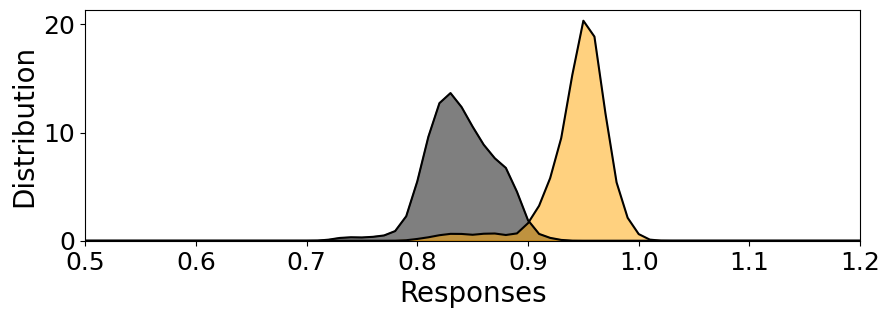

------ Distribution of normalized L3 responses under shade and sun conditions ------
 ------ Pooling size: ------- 4


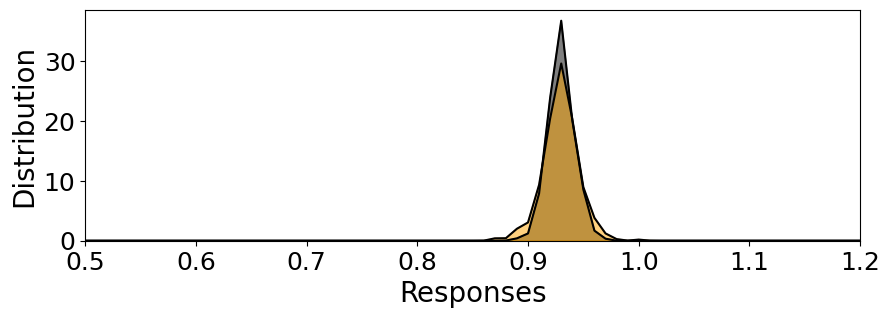

------ Distribution of normalized L3 responses under shade and sun conditions ------
 ------ Pooling size: ------- 92


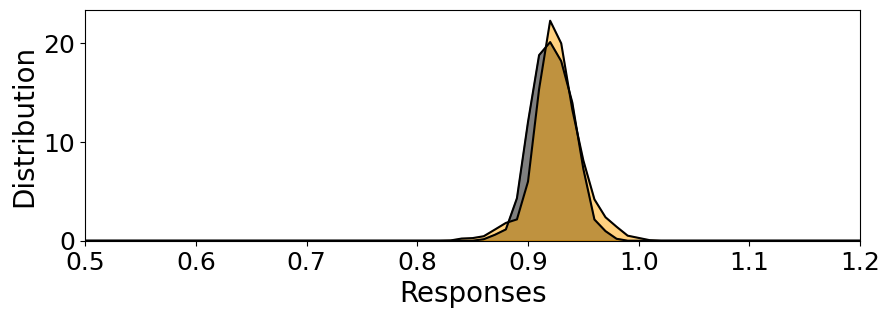

3
4


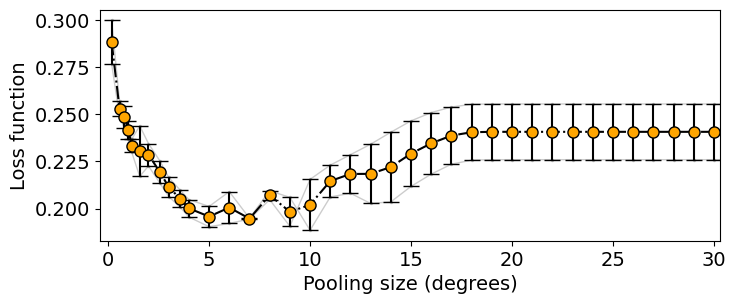

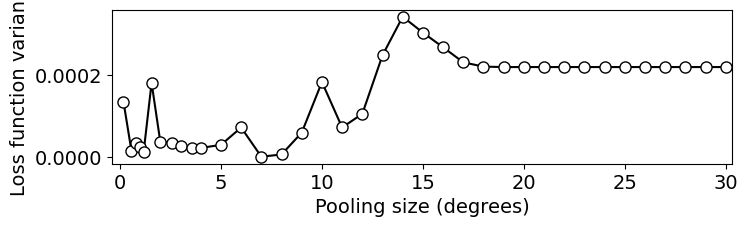

In [123]:
# -------------------- Visualize luminance response distributions --------------------

N_pooling_array_ = np.copy(N_pooling_array)
#N_pooling_array_ = np.append(N_pooling_array, int(46*0.1*100))

String_L3 = ['L3', 'L3_Norm']
print("------ Distribution of L3 responses under shade and sun conditions ------")
Visualize_distributions(x_array_l3, dist1_l3_copy, dist2_l3_copy, parameters, 0, 0)
for i_pooling in np.array([0, 10]):
    print("------ Distribution of normalized L3 responses under shade and sun conditions ------")
    print(" ------ Pooling size: -------", N_pooling_array[i_pooling])
    contrast_l3_norm_1, contrast_l3_norm_2 = Responses_from_trajectory(L3_norm[:, i_pooling, :, :], N_idist_plot_2)
    x_array_l3_norm, dist1_l3_norm, dist2_l3_norm = Dist_responses(Hist_min_l3_norm, Hist_max_l3_norm, contrast_l3_norm_1, contrast_l3_norm_2)
    Visualize_distributions(x_array_l3_norm, dist1_l3_norm, dist2_l3_norm, parameters, 1, i_pooling)

# -------------------- Visualize loss function as a function of pooling size --------------------
# LF_ = np.copy(LF/dist_l3)

plt.figure(figsize = (8, 3))
LF_norm = np.zeros((N_N_idist, N_pooling))
counter_i_N_idist = -1
for i_N_idist in i_N_idist_array:
    print(i_N_idist)
    counter_i_N_idist += 1
    plt.plot(2*N_pooling_array_/46, LF[counter_i_N_idist]/dist_l3[counter_i_N_idist], color = 'k', linestyle = '-', alpha = 0.2, linewidth = 1, marker = '.', markersize = 3)
    LF_norm[counter_i_N_idist,:] = LF[counter_i_N_idist,:]/dist_l3[counter_i_N_idist]
#plt.plot(2*N_pooling_array_/46, LF[counter_i_N_idist]/dist_l3[counter_i_N_idist], color = 'k', linestyle = '-', alpha = 0.1, linewidth = 2, marker = '.', label = 'Traces per lit condition pair')
plt.errorbar(2*N_pooling_array_/46, np.mean(LF_norm, axis = 0), yerr = np.std(LF_norm, axis = 0), marker = 'o', color = 'k', markeredgecolor = 'k', markerfacecolor = 'orange', markeredgewidth = 1, markersize = 8, linestyle = '-.', capsize = 6, label = 'Mean over traces')
plt.xlabel("Pooling size (degrees)", fontsize = 14)
plt.ylabel("Loss function", fontsize = 14)
plt.tick_params(labelsize = 14)
# plt.legend(fontsize = 13)
if par_dset_wide == 0:
    plt.xlim(-0.4, 30.3)
else:
    plt.xlim(-0.4, 30.3)
plt.savefig("Plots/Lossfunction_"+str(string[par_dset_wide])+"_all_trajectories_"+str(Tr_type)+"_.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()

plt.figure(figsize = (8, 2))
plt.plot(2*N_pooling_array_/46, np.std(LF_norm, axis = 0)**2, marker = 'o', color = 'k', markeredgecolor = 'k', markerfacecolor = 'white', markeredgewidth = 1, markersize = 8, linestyle = '-', label = 'Mean over traces')
if par_dset_wide == 0:
    plt.xlim(-0.4, 30.3)
else:
    plt.xlim(-0.4, 30.3)
plt.xlabel("Pooling size (degrees)", fontsize = 14)
plt.ylabel("Loss function variance", fontsize = 14)
plt.tick_params(labelsize = 14)
plt.savefig("Plots/Lossfunction_variance_"+str(string[par_dset_wide])+"_all_trajectories_"+str(Tr_type)+".pdf", dpi = 300, bbox_inches = 'tight')

# plt.legend(fontsize = 13)
# plt.axhline(y=1, color = 'k', linestyle = '-.')
#plt.savefig("Plots/Lossfunction_all.pdf", dpi = 300, bbox_inches = 'tight')